# Q-Learning Implementation to Solve MountainCar-v0

### Explore Environment

In [22]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make("MountainCar-v0")
env.reset()

array([-0.5677043,  0.       ], dtype=float32)

In [4]:
env.action_space

Discrete(3)

In [25]:
env.action_space.n

3

In [18]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [62]:
env.goal_position

0.5

In [14]:
done=False
while not done:
    action=2
    new_state, reward, done, _ = env.step(action)
    env.render()

In [15]:
env.close()

### Create Q table

#### Step1: Discretize the state values to create a managable q table

In [19]:
print(env.observation_space.high)
print(env.observation_space.low)

[0.6  0.07]
[-1.2  -0.07]


In [36]:
discrete_os_size = [20, 20] #this thing should be tweaked for each env
dicrete_os_win_size = (env.observation_space.high - env.observation_space.low)/discrete_os_size
dicrete_os_win_size

array([0.09 , 0.007])

In [37]:
#low and high should be customized for each env
q_table = np.random.uniform(
    low=-2, 
    high=0, 
    size=(discrete_os_size + [env.action_space.n])
)

q_table.shape

(20, 20, 3)

So, this is a 20x20x3 shape, which has initialized random Q values for us. The 20 x 20 bit is every combination of the bucket slices of all possible states. The x3 bit is for every possible action we could take.

In [38]:
q_table

array([[[-1.34214757, -0.16869369, -0.10659519],
        [-0.81238145, -1.65745045, -0.89420143],
        [-0.86475932, -1.83438542, -0.83603613],
        ...,
        [-1.70796717, -1.72106592, -0.53433575],
        [-1.58019757, -1.89824894, -0.27172608],
        [-0.01234442, -0.78103613, -1.53093164]],

       [[-0.10235377, -0.51600666, -1.42992344],
        [-1.86532056, -0.84157696, -0.73510265],
        [-0.26999724, -0.21530773, -0.73875122],
        ...,
        [-1.4869331 , -1.74129713, -0.47014459],
        [-1.41559724, -1.49601407, -1.29422918],
        [-0.0781077 , -0.86582281, -0.41597002]],

       [[-0.48104877, -0.07200128, -1.38704642],
        [-1.61990774, -0.6448477 , -1.23305765],
        [-0.39954008, -0.25651609, -0.07702175],
        ...,
        [-1.91296327, -1.75638114, -0.89282144],
        [-0.2262999 , -1.35063746, -0.37391111],
        [-0.94714217, -1.08419137, -0.58801731]],

       ...,

       [[-0.70736144, -1.13583797, -1.86718406],
        [-1

In [88]:
Learning_rate = 0.1
discount = 0.95 #measure of how impotant we find the future actions
episodes=1000
show_every = 25
epsilon = 0.5
start_epsilon_decaying = 1
end_epsilon_decaying = episodes//2
epsilon_decay_value = epsilon/(end_epsilon_decaying - start_epsilon_decaying)

In [89]:
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/dicrete_os_win_size
    return tuple(discrete_state.astype(np.int))

In [61]:
discrete_state = get_discrete_state(env.reset())
discrete_state

(6, 10)

In [57]:
q_table[discrete_state]

array([-1.58776375, -0.89872257, -1.92807798])

In [58]:
print(np.argmax(q_table[discrete_state]))

1


Therefore we can go with action 1

### Run Q Learning 

In [92]:
####Metrics to track episode wise reward
ep_rewards = []
agg_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}


for ep in range(episodes):
    ### Initialize episode reward as 0
    episode_reward = 0
    
    ### Print episode_no and render only for every <show_every> episodes
    if ep%show_every == 0:
        render=True
        print(f"Episode No: {ep}")
    else:
        render=False
    
    ### Discritize the environent states for the q_table
    discrete_state = get_discrete_state(env.reset())
    
    done=False
    
    while not done:
        ###explore vs exploit using epsilon greedy method
        if np.random.random() > epsilon:
            ### Decide Action --> exploit
            action=np.argmax(q_table[discrete_state])
        else:
            ### Decide Action --> explore
            action = np.random.randint(0, env.action_space.n)
        
        ### Take Action in the environment and get reward, done, and new_state
        new_state, reward, done, _ = env.step(action)
        
        ### Accumulate Rewards for this episode
        episode_reward += reward
        
        ### Discritize the environent states for the q_table
        new_discrete_state = get_discrete_state(new_state)
        
        if render:
            env.render()
        
        if not done:
            #### Update q table
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]

            new_q = (1 - Learning_rate) * current_q + Learning_rate * (reward + discount * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        elif new_state[0] >= env.goal_position:
            print(f'We made it on top in episode {ep}; Epsilon:{epsilon}')
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state
    
    ###Decay epsilon value
    if end_epsilon_decaying >= ep >= start_epsilon_decaying:
        epsilon -= epsilon_decay_value

    
    ###Update the metrics dictionary
    ep_rewards.append(episode_reward)
    if ep%show_every != 0:
        average_reward = sum(ep_rewards[-show_every:])/len(ep_rewards[-show_every:])
        agg_ep_rewards['ep'].append(ep)
        agg_ep_rewards['avg'].append(average_reward)
        
        min_ep_reward = min(ep_rewards[-show_every:])
        agg_ep_rewards['min'].append(min_ep_reward)
        
        max_ep_reward = max(ep_rewards[-show_every:])
        agg_ep_rewards['max'].append(max_ep_reward)
        
        ### Print Metrics
        print(f"Episode: {ep}; Avg_Reward: {average_reward}; Min_Reward: {min_ep_reward}; Max_Reward: {max_ep_reward}")

####Close Environment
env.close()

Episode No: 0
Episode: 1; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 2; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 3; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 4; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 5; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 6; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 7; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 8; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 9; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 10; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 11; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 12; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 13; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Reward: -200.0
Episode: 14; Avg_Reward: -200.0; Min_Reward: -200.0; Max_Re

Episode: 112; Avg_Reward: -198.4; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 113; Avg_Reward: -198.4; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 114; Avg_Reward: -198.4; Min_Reward: -200.0; Max_Reward: -160.0
We made it on top in episode 115; Epsilon:0.3847695390781562
Episode: 115; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 116; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 117; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 118; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 119; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 120; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 121; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 122; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 123; Avg_Reward: -197.04; Min_Reward: -200.0; Max_Reward: -160.0
Episode: 124; Avg_Reward: -197.04; Min_Reward: -200.0;

We made it on top in episode 209; Epsilon:0.2905811623246491
Episode: 209; Avg_Reward: -183.16; Min_Reward: -200.0; Max_Reward: -151.0
Episode: 210; Avg_Reward: -183.16; Min_Reward: -200.0; Max_Reward: -151.0
Episode: 211; Avg_Reward: -183.16; Min_Reward: -200.0; Max_Reward: -151.0
Episode: 212; Avg_Reward: -183.16; Min_Reward: -200.0; Max_Reward: -151.0
Episode: 213; Avg_Reward: -184.32; Min_Reward: -200.0; Max_Reward: -151.0
Episode: 214; Avg_Reward: -184.32; Min_Reward: -200.0; Max_Reward: -151.0
Episode: 215; Avg_Reward: -185.6; Min_Reward: -200.0; Max_Reward: -151.0
Episode: 216; Avg_Reward: -185.6; Min_Reward: -200.0; Max_Reward: -151.0
We made it on top in episode 217; Epsilon:0.2825651302605208
Episode: 217; Avg_Reward: -185.6; Min_Reward: -200.0; Max_Reward: -151.0
Episode: 218; Avg_Reward: -185.6; Min_Reward: -200.0; Max_Reward: -151.0
We made it on top in episode 219; Epsilon:0.28056112224448876
Episode: 219; Avg_Reward: -186.36; Min_Reward: -200.0; Max_Reward: -151.0
We mad

We made it on top in episode 286; Epsilon:0.21342685370741454
Episode: 286; Avg_Reward: -181.88; Min_Reward: -200.0; Max_Reward: -153.0
We made it on top in episode 287; Epsilon:0.2124248496993985
Episode: 287; Avg_Reward: -180.04; Min_Reward: -200.0; Max_Reward: -153.0
We made it on top in episode 288; Epsilon:0.21142284569138248
Episode: 288; Avg_Reward: -180.28; Min_Reward: -200.0; Max_Reward: -153.0
We made it on top in episode 289; Epsilon:0.21042084168336644
Episode: 289; Avg_Reward: -179.84; Min_Reward: -200.0; Max_Reward: -152.0
We made it on top in episode 290; Epsilon:0.2094188376753504
Episode: 290; Avg_Reward: -178.28; Min_Reward: -200.0; Max_Reward: -152.0
Episode: 291; Avg_Reward: -178.28; Min_Reward: -200.0; Max_Reward: -152.0
We made it on top in episode 292; Epsilon:0.20741482965931834
Episode: 292; Avg_Reward: -178.28; Min_Reward: -200.0; Max_Reward: -152.0
We made it on top in episode 293; Epsilon:0.2064128256513023
Episode: 293; Avg_Reward: -178.28; Min_Reward: -200

We made it on top in episode 360; Epsilon:0.1392785571142281
Episode: 360; Avg_Reward: -174.72; Min_Reward: -200.0; Max_Reward: -135.0
We made it on top in episode 361; Epsilon:0.13827655310621206
Episode: 361; Avg_Reward: -173.68; Min_Reward: -200.0; Max_Reward: -135.0
We made it on top in episode 362; Epsilon:0.13727454909819603
Episode: 362; Avg_Reward: -172.68; Min_Reward: -200.0; Max_Reward: -135.0
We made it on top in episode 363; Epsilon:0.13627254509018
Episode: 363; Avg_Reward: -171.12; Min_Reward: -200.0; Max_Reward: -135.0
Episode: 364; Avg_Reward: -171.28; Min_Reward: -200.0; Max_Reward: -135.0
Episode: 365; Avg_Reward: -172.08; Min_Reward: -200.0; Max_Reward: -135.0
We made it on top in episode 366; Epsilon:0.1332665330661319
Episode: 366; Avg_Reward: -171.36; Min_Reward: -200.0; Max_Reward: -135.0
We made it on top in episode 367; Epsilon:0.13226452905811587
Episode: 367; Avg_Reward: -173.04; Min_Reward: -200.0; Max_Reward: -145.0
Episode: 368; Avg_Reward: -173.64; Min_Re

We made it on top in episode 438; Epsilon:0.06112224448897752
Episode: 438; Avg_Reward: -161.0; Min_Reward: -200.0; Max_Reward: -124.0
We made it on top in episode 439; Epsilon:0.060120240480961484
Episode: 439; Avg_Reward: -161.28; Min_Reward: -200.0; Max_Reward: -124.0
We made it on top in episode 440; Epsilon:0.05911823647294545
Episode: 440; Avg_Reward: -159.24; Min_Reward: -180.0; Max_Reward: -124.0
We made it on top in episode 441; Epsilon:0.05811623246492942
Episode: 441; Avg_Reward: -157.04; Min_Reward: -180.0; Max_Reward: -113.0
We made it on top in episode 442; Epsilon:0.057114228456913385
Episode: 442; Avg_Reward: -155.36; Min_Reward: -180.0; Max_Reward: -113.0
We made it on top in episode 443; Epsilon:0.05611222444889735
Episode: 443; Avg_Reward: -153.56; Min_Reward: -180.0; Max_Reward: -113.0
We made it on top in episode 444; Epsilon:0.05511022044088132
Episode: 444; Avg_Reward: -154.08; Min_Reward: -180.0; Max_Reward: -113.0
We made it on top in episode 445; Epsilon:0.054

We made it on top in episode 500; Epsilon:-0.0010020040080165103
We made it on top in episode 501; Epsilon:-0.0020040080160325423
Episode: 501; Avg_Reward: -164.8; Min_Reward: -191.0; Max_Reward: -110.0
We made it on top in episode 502; Epsilon:-0.0020040080160325423
Episode: 502; Avg_Reward: -164.8; Min_Reward: -191.0; Max_Reward: -110.0
We made it on top in episode 503; Epsilon:-0.0020040080160325423
Episode: 503; Avg_Reward: -164.64; Min_Reward: -191.0; Max_Reward: -110.0
We made it on top in episode 504; Epsilon:-0.0020040080160325423
Episode: 504; Avg_Reward: -164.52; Min_Reward: -191.0; Max_Reward: -110.0
We made it on top in episode 505; Epsilon:-0.0020040080160325423
Episode: 505; Avg_Reward: -165.24; Min_Reward: -191.0; Max_Reward: -110.0
We made it on top in episode 506; Epsilon:-0.0020040080160325423
Episode: 506; Avg_Reward: -165.32; Min_Reward: -191.0; Max_Reward: -110.0
We made it on top in episode 507; Epsilon:-0.0020040080160325423
Episode: 507; Avg_Reward: -168.36; Min

We made it on top in episode 564; Epsilon:-0.0020040080160325423
Episode: 564; Avg_Reward: -171.96; Min_Reward: -195.0; Max_Reward: -155.0
We made it on top in episode 565; Epsilon:-0.0020040080160325423
Episode: 565; Avg_Reward: -171.84; Min_Reward: -195.0; Max_Reward: -155.0
We made it on top in episode 566; Epsilon:-0.0020040080160325423
Episode: 566; Avg_Reward: -170.6; Min_Reward: -195.0; Max_Reward: -154.0
We made it on top in episode 567; Epsilon:-0.0020040080160325423
Episode: 567; Avg_Reward: -169.96; Min_Reward: -195.0; Max_Reward: -154.0
We made it on top in episode 568; Epsilon:-0.0020040080160325423
Episode: 568; Avg_Reward: -170.28; Min_Reward: -195.0; Max_Reward: -154.0
We made it on top in episode 569; Epsilon:-0.0020040080160325423
Episode: 569; Avg_Reward: -170.28; Min_Reward: -195.0; Max_Reward: -154.0
We made it on top in episode 570; Epsilon:-0.0020040080160325423
Episode: 570; Avg_Reward: -169.92; Min_Reward: -195.0; Max_Reward: -154.0
We made it on top in episode

We made it on top in episode 625; Epsilon:-0.0020040080160325423
We made it on top in episode 626; Epsilon:-0.0020040080160325423
Episode: 626; Avg_Reward: -168.12; Min_Reward: -183.0; Max_Reward: -155.0
We made it on top in episode 627; Epsilon:-0.0020040080160325423
Episode: 627; Avg_Reward: -168.72; Min_Reward: -183.0; Max_Reward: -156.0
We made it on top in episode 628; Epsilon:-0.0020040080160325423
Episode: 628; Avg_Reward: -169.24; Min_Reward: -183.0; Max_Reward: -156.0
We made it on top in episode 629; Epsilon:-0.0020040080160325423
Episode: 629; Avg_Reward: -168.68; Min_Reward: -183.0; Max_Reward: -156.0
We made it on top in episode 630; Epsilon:-0.0020040080160325423
Episode: 630; Avg_Reward: -168.52; Min_Reward: -183.0; Max_Reward: -156.0
We made it on top in episode 631; Epsilon:-0.0020040080160325423
Episode: 631; Avg_Reward: -167.88; Min_Reward: -183.0; Max_Reward: -156.0
We made it on top in episode 632; Epsilon:-0.0020040080160325423
Episode: 632; Avg_Reward: -167.76; M

We made it on top in episode 690; Epsilon:-0.0020040080160325423
Episode: 690; Avg_Reward: -162.04; Min_Reward: -178.0; Max_Reward: -149.0
We made it on top in episode 691; Epsilon:-0.0020040080160325423
Episode: 691; Avg_Reward: -162.72; Min_Reward: -178.0; Max_Reward: -149.0
We made it on top in episode 692; Epsilon:-0.0020040080160325423
Episode: 692; Avg_Reward: -163.56; Min_Reward: -178.0; Max_Reward: -149.0
We made it on top in episode 693; Epsilon:-0.0020040080160325423
Episode: 693; Avg_Reward: -164.4; Min_Reward: -178.0; Max_Reward: -149.0
We made it on top in episode 694; Epsilon:-0.0020040080160325423
Episode: 694; Avg_Reward: -164.04; Min_Reward: -178.0; Max_Reward: -149.0
We made it on top in episode 695; Epsilon:-0.0020040080160325423
Episode: 695; Avg_Reward: -164.4; Min_Reward: -178.0; Max_Reward: -149.0
We made it on top in episode 696; Epsilon:-0.0020040080160325423
Episode: 696; Avg_Reward: -165.28; Min_Reward: -178.0; Max_Reward: -149.0
We made it on top in episode 

We made it on top in episode 750; Epsilon:-0.0020040080160325423
We made it on top in episode 751; Epsilon:-0.0020040080160325423
Episode: 751; Avg_Reward: -161.76; Min_Reward: -174.0; Max_Reward: -147.0
We made it on top in episode 752; Epsilon:-0.0020040080160325423
Episode: 752; Avg_Reward: -160.84; Min_Reward: -174.0; Max_Reward: -147.0
We made it on top in episode 753; Epsilon:-0.0020040080160325423
Episode: 753; Avg_Reward: -160.52; Min_Reward: -172.0; Max_Reward: -147.0
We made it on top in episode 754; Epsilon:-0.0020040080160325423
Episode: 754; Avg_Reward: -160.8; Min_Reward: -172.0; Max_Reward: -147.0
We made it on top in episode 755; Epsilon:-0.0020040080160325423
Episode: 755; Avg_Reward: -160.24; Min_Reward: -172.0; Max_Reward: -147.0
We made it on top in episode 756; Epsilon:-0.0020040080160325423
Episode: 756; Avg_Reward: -160.32; Min_Reward: -172.0; Max_Reward: -147.0
We made it on top in episode 757; Epsilon:-0.0020040080160325423
Episode: 757; Avg_Reward: -161.04; Mi

We made it on top in episode 814; Epsilon:-0.0020040080160325423
Episode: 814; Avg_Reward: -161.2; Min_Reward: -178.0; Max_Reward: -148.0
We made it on top in episode 815; Epsilon:-0.0020040080160325423
Episode: 815; Avg_Reward: -161.16; Min_Reward: -178.0; Max_Reward: -148.0
We made it on top in episode 816; Epsilon:-0.0020040080160325423
Episode: 816; Avg_Reward: -161.36; Min_Reward: -178.0; Max_Reward: -148.0
We made it on top in episode 817; Epsilon:-0.0020040080160325423
Episode: 817; Avg_Reward: -161.04; Min_Reward: -178.0; Max_Reward: -147.0
We made it on top in episode 818; Epsilon:-0.0020040080160325423
Episode: 818; Avg_Reward: -160.72; Min_Reward: -178.0; Max_Reward: -147.0
We made it on top in episode 819; Epsilon:-0.0020040080160325423
Episode: 819; Avg_Reward: -160.0; Min_Reward: -175.0; Max_Reward: -147.0
We made it on top in episode 820; Epsilon:-0.0020040080160325423
Episode: 820; Avg_Reward: -160.24; Min_Reward: -175.0; Max_Reward: -147.0
We made it on top in episode 

Episode: 886; Avg_Reward: -178.8; Min_Reward: -200.0; Max_Reward: -143.0
Episode: 887; Avg_Reward: -181.08; Min_Reward: -200.0; Max_Reward: -143.0
Episode: 888; Avg_Reward: -181.08; Min_Reward: -200.0; Max_Reward: -143.0
We made it on top in episode 889; Epsilon:-0.0020040080160325423
Episode: 889; Avg_Reward: -182.12; Min_Reward: -200.0; Max_Reward: -143.0
We made it on top in episode 890; Epsilon:-0.0020040080160325423
Episode: 890; Avg_Reward: -182.84; Min_Reward: -200.0; Max_Reward: -146.0
We made it on top in episode 891; Epsilon:-0.0020040080160325423
Episode: 891; Avg_Reward: -183.68; Min_Reward: -200.0; Max_Reward: -147.0
We made it on top in episode 892; Epsilon:-0.0020040080160325423
Episode: 892; Avg_Reward: -183.28; Min_Reward: -200.0; Max_Reward: -147.0
We made it on top in episode 893; Epsilon:-0.0020040080160325423
Episode: 893; Avg_Reward: -182.32; Min_Reward: -200.0; Max_Reward: -147.0
We made it on top in episode 894; Epsilon:-0.0020040080160325423
Episode: 894; Avg_R

We made it on top in episode 976; Epsilon:-0.0020040080160325423
Episode: 976; Avg_Reward: -188.44; Min_Reward: -200.0; Max_Reward: -144.0
Episode: 977; Avg_Reward: -188.44; Min_Reward: -200.0; Max_Reward: -144.0
We made it on top in episode 978; Epsilon:-0.0020040080160325423
Episode: 978; Avg_Reward: -188.32; Min_Reward: -200.0; Max_Reward: -144.0
We made it on top in episode 979; Epsilon:-0.0020040080160325423
Episode: 979; Avg_Reward: -188.2; Min_Reward: -200.0; Max_Reward: -144.0
Episode: 980; Avg_Reward: -188.2; Min_Reward: -200.0; Max_Reward: -144.0
We made it on top in episode 981; Epsilon:-0.0020040080160325423
Episode: 981; Avg_Reward: -188.2; Min_Reward: -200.0; Max_Reward: -144.0
We made it on top in episode 982; Epsilon:-0.0020040080160325423
Episode: 982; Avg_Reward: -187.4; Min_Reward: -200.0; Max_Reward: -144.0
We made it on top in episode 983; Epsilon:-0.0020040080160325423
Episode: 983; Avg_Reward: -189.48; Min_Reward: -200.0; Max_Reward: -144.0
Episode: 984; Avg_Rewa

In [87]:
env.close()

### Agent Analysis

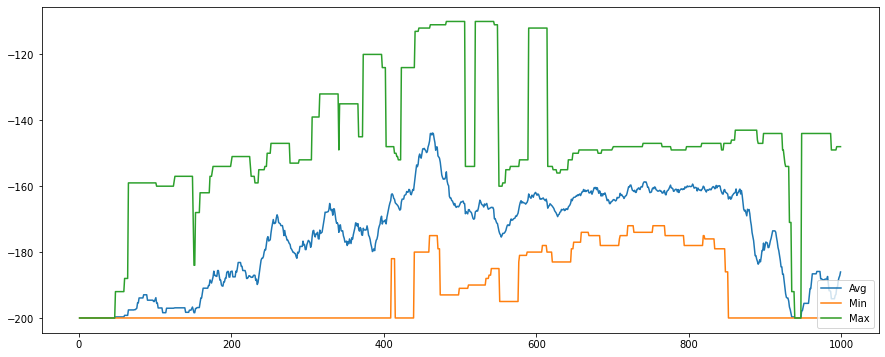

In [94]:
plt.figure(figsize=(15,6))
plt.plot(agg_ep_rewards['ep'], agg_ep_rewards['avg'], label='Avg')
plt.plot(agg_ep_rewards['ep'], agg_ep_rewards['min'], label='Min')
plt.plot(agg_ep_rewards['ep'], agg_ep_rewards['max'], label='Max')
plt.legend(loc=4)
plt.show();